**Combining datasets**

In [2]:
import os
import shutil
from random import sample

def combine_datasets(dataset1_path, dataset2_path, output_dataset_path, max_images_per_class):
    # Ensure output path exists
    os.makedirs(output_dataset_path, exist_ok=True)

    # Function to get class names from a dataset path
    def get_class_names(dataset_path):
        return [name for name in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, name))]

    # Get class names from both datasets and ensure uniqueness
    dataset1_classes = get_class_names(dataset1_path)
    dataset2_classes = get_class_names(dataset2_path)
    combined_classes = list(set(dataset1_classes + dataset2_classes))  # Combine and ensure uniqueness

    for class_name in combined_classes:
        output_class_path = os.path.join(output_dataset_path, class_name)
        os.makedirs(output_class_path, exist_ok=True)  # Ensure output class directory exists

        # Handle Classes from Both Datasets
        for dataset_path, dataset_name in [(dataset1_path, 'Dataset 1'), (dataset2_path, 'Dataset 2')]:
            class_path = os.path.join(dataset_path, class_name)
            if os.path.exists(class_path):
                images = [f for f in os.listdir(class_path) if f.endswith('.jpg') or f.endswith('.png')]
                images_to_move = images[:max_images_per_class]  # Limit to max_images_per_class
                for image in images_to_move:
                    shutil.move(os.path.join(class_path, image), output_class_path)

                # If not enough images in the first dataset, fill up to max_images_per_class from the second dataset
                remaining_slots = max_images_per_class - len(os.listdir(output_class_path))
                if remaining_slots > 0:
                    additional_images = sample([img for img in images if img not in images_to_move], min(remaining_slots, len(images)))
                    for image in additional_images:
                        shutil.move(os.path.join(class_path, image), output_class_path)

# Example usage
if __name__ == "__main__":
    combine_datasets(
        dataset1_path="D:/Github/Datasets/Indian Food Images/Indian Food Images",
        dataset2_path="D:/Github/Datasets/indian20/dataset/Dataset/train",
        output_dataset_path="D:/Github/Datasets/combined_indian_dataset",
        max_images_per_class=50
    )

In [3]:
len(os.listdir("D:/Github/Datasets/combined_indian_dataset"))

96

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow 
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D,MaxPooling2D,Flatten,InputLayer,AveragePooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization,Dropout,Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, InceptionV3, ResNet50,MobileNetV2, VGG19
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score, recall_score
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.applications.mobilenet_v2 import preprocess_input
import pickle

**Data frame Creation**

In [27]:
path = "D:/Github/Datasets/combined_indian_dataset"

labels = os.listdir(path)
df = pd.DataFrame(columns=['img_path','label'])

for label in labels:
    img_dir_path = os.path.join(path,label)
    for img in os.listdir(img_dir_path):
        img_path = os.path.join(img_dir_path,img)
        df.loc[df.shape[0]] = [img_path,label]
        
# shuffling dataset
df = df.sample(frac=1).reset_index(drop=True)

In [28]:
df

,img_path,label
0,D:/Github/Datasets/combined_indian_dataset\sut...,sutar_feni
1,D:/Github/Datasets/combined_indian_dataset\paa...,paani_puri
2,D:/Github/Datasets/combined_indian_dataset\sam...,samosa
3,D:/Github/Datasets/combined_indian_dataset\kof...,kofta
4,D:/Github/Datasets/combined_indian_dataset\ima...,imarti
...,...,...
4795,D:/Github/Datasets/combined_indian_dataset\poo...,pootharekulu
4796,D:/Github/Datasets/combined_indian_dataset\chi...,chicken_tikka_masala
4797,D:/Github/Datasets/combined_indian_dataset\gav...,gavvalu
4798,D:/Github/Datasets/combined_indian_dataset\ghe...,ghevar


In [24]:
print("Number of Images: ",df.shape[0])
print("Number of labels: ",df['label'].nunique())

print('There are only 50 images per class')
print(96*50)

Number of Images:  4900
Number of labels:  96
There are only 50 images per class
4800


there was a mistake somewhere where we got 200 extra images.

In [25]:
for label in os.listdir(path):
    img_dir_path = os.path.join(path,label)
    print(label, len(os.listdir(img_dir_path)))


adhirasam 50
aloo_gobi 50
aloo_matar 50
aloo_methi 50
aloo_shimla_mirch 50
aloo_tikki 50
anarsa 50
ariselu 50
bandar_laddu 50
basundi 50
bhatura 50
bhindi_masala 50
biryani 50
boondi 50
burger 50
butter_chicken 50
butter_naan 50
chai 50
chak_hao_kheer 50
cham_cham 50
chana_masala 50
chapati 50
chhena_kheeri 50
chicken_razala 50
chicken_tikka 50
chicken_tikka_masala 50
chikki 50
chole_bhature 50
daal_baati_churma 50
daal_puri 50
dal_makhani 50
dal_tadka 50
dharwad_pedha 50
dhokla 50
doodhpak 50
double_ka_meetha 50
dum_aloo 50
fried_rice 50
gajar_ka_halwa 50
gavvalu 50
ghevar 50
gulab_jamun 50
idli 50
imarti 50
jalebi 100
kaathi_rolls 50
kachori 50
kadai_paneer 100
kadhi_pakoda 50
kajjikaya 50
kakinada_khaja 50
kalakand 50
karela_bharta 50
kofta 50
kulfi 50
kuzhi_paniyaram 50
lassi 50
ledikeni 50
litti_chokha 50
lyangcha 50
maach_jhol 50
makki_di_roti_sarson_da_saag 50
malapua 50
masala_dosa 50
misi_roti 50
misti_doi 50
modak 50
momos 50
mysore_pak 50
naan 50
navrattan_korma 50
paani_pur

fixed it

In [29]:
print("Number of Images: ",df.shape[0])
print("Number of labels: ",df['label'].nunique())

Number of Images:  4800
Number of labels:  96


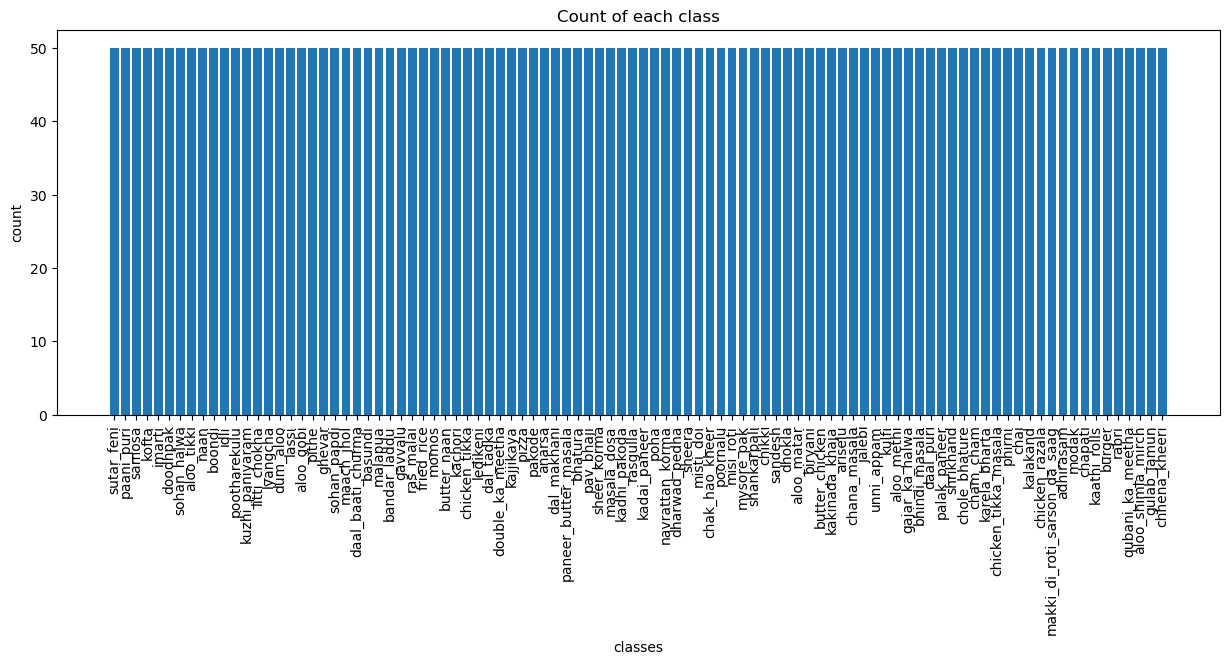

In [30]:
plt.figure(figsize=(15,5))
plt.bar(x = df['label'].unique(),height=df['label'].value_counts())
plt.xlabel('classes')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.title('Count of each class')
plt.show()

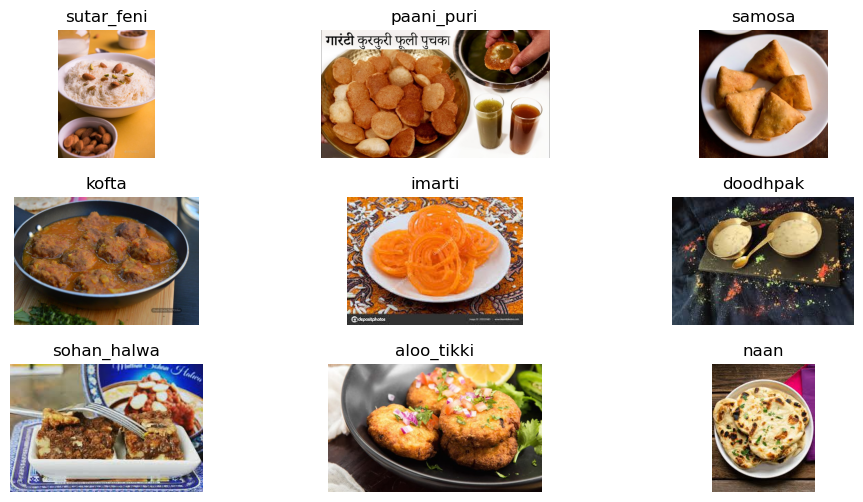

In [33]:
plt.figure(figsize=(12,6))

for i in range(1,4):
    for j in range(1,4):
        plt.subplot(3,3,3*(i-1) + j)
        img_data = cv2.imread(df['img_path'][3*(i-1) + (j-1)])
        image_rgb = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB) # BGR to RGB format
        plt.imshow(image_rgb)
        plt.title(df['label'][3*(i-1) + (j-1)])
        plt.axis('off')

plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

**TRAIN TEST SPLIT**

In [34]:
x_train, x_val, y_train, y_val = train_test_split(df['img_path'], df['label'], random_state = 42, test_size = 0.2)

**Preprocess and Augmentation**

In [36]:
def preprocess(img_paths):
    images = []
    for img_path in img_paths:
        img_data = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
        image_resized = cv2.resize(img_rgb, (224, 224))
        image_normalized = image_resized.astype('float32') / 255
        images.append(image_normalized)

    return np.array(images)

In [38]:
#augmention
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2, #horizontal shift
    height_shift_range=0.2, #vertical shift
    shear_range=0.2,
    zoom_range=0.2, #random zoom
    horizontal_flip=True, #random horizontal flips
    fill_mode='nearest' 
)

In [39]:
train_dataset = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'img_path':x_train,'label':y_train}),
    x_col='img_path',
    y_col='label',
    target_size=(224, 224),  
    batch_size=32,
    class_mode='categorical', 
    shuffle=True,
    seed=42,
    subset='training'  
)

Found 3840 validated image filenames belonging to 96 classes.


In [40]:
class_indices = train_dataset.class_indices

# Print the class indices dictionary
print("Class Indices:")
print(class_indices)

Class Indices:
{'adhirasam': 0, 'aloo_gobi': 1, 'aloo_matar': 2, 'aloo_methi': 3, 'aloo_shimla_mirch': 4, 'aloo_tikki': 5, 'anarsa': 6, 'ariselu': 7, 'bandar_laddu': 8, 'basundi': 9, 'bhatura': 10, 'bhindi_masala': 11, 'biryani': 12, 'boondi': 13, 'burger': 14, 'butter_chicken': 15, 'butter_naan': 16, 'chai': 17, 'chak_hao_kheer': 18, 'cham_cham': 19, 'chana_masala': 20, 'chapati': 21, 'chhena_kheeri': 22, 'chicken_razala': 23, 'chicken_tikka': 24, 'chicken_tikka_masala': 25, 'chikki': 26, 'chole_bhature': 27, 'daal_baati_churma': 28, 'daal_puri': 29, 'dal_makhani': 30, 'dal_tadka': 31, 'dharwad_pedha': 32, 'dhokla': 33, 'doodhpak': 34, 'double_ka_meetha': 35, 'dum_aloo': 36, 'fried_rice': 37, 'gajar_ka_halwa': 38, 'gavvalu': 39, 'ghevar': 40, 'gulab_jamun': 41, 'idli': 42, 'imarti': 43, 'jalebi': 44, 'kaathi_rolls': 45, 'kachori': 46, 'kadai_paneer': 47, 'kadhi_pakoda': 48, 'kajjikaya': 49, 'kakinada_khaja': 50, 'kalakand': 51, 'karela_bharta': 52, 'kofta': 53, 'kulfi': 54, 'kuzhi_pan

index_to_class directory

In [43]:
index_to_class = {v: k for k, v in class_indices.items()}
print("Index to Class Mapping:")
print(index_to_class)

Index to Class Mapping:
{0: 'adhirasam', 1: 'aloo_gobi', 2: 'aloo_matar', 3: 'aloo_methi', 4: 'aloo_shimla_mirch', 5: 'aloo_tikki', 6: 'anarsa', 7: 'ariselu', 8: 'bandar_laddu', 9: 'basundi', 10: 'bhatura', 11: 'bhindi_masala', 12: 'biryani', 13: 'boondi', 14: 'burger', 15: 'butter_chicken', 16: 'butter_naan', 17: 'chai', 18: 'chak_hao_kheer', 19: 'cham_cham', 20: 'chana_masala', 21: 'chapati', 22: 'chhena_kheeri', 23: 'chicken_razala', 24: 'chicken_tikka', 25: 'chicken_tikka_masala', 26: 'chikki', 27: 'chole_bhature', 28: 'daal_baati_churma', 29: 'daal_puri', 30: 'dal_makhani', 31: 'dal_tadka', 32: 'dharwad_pedha', 33: 'dhokla', 34: 'doodhpak', 35: 'double_ka_meetha', 36: 'dum_aloo', 37: 'fried_rice', 38: 'gajar_ka_halwa', 39: 'gavvalu', 40: 'ghevar', 41: 'gulab_jamun', 42: 'idli', 43: 'imarti', 44: 'jalebi', 45: 'kaathi_rolls', 46: 'kachori', 47: 'kadai_paneer', 48: 'kadhi_pakoda', 49: 'kajjikaya', 50: 'kakinada_khaja', 51: 'kalakand', 52: 'karela_bharta', 53: 'kofta', 54: 'kulfi', 5

**Model Training**

In [49]:
def build_model(base):
    base_model = base
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        Flatten(),
        
        Dense(256, activation='relu'),
        Dropout(0.25),
        BatchNormalization(),
        
        Dense(128, activation='relu'),
        Dropout(0.25),
        BatchNormalization(),
        
        Dense(96, activation='softmax'),  # For binary classification
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

**TRANSFER LEARNING**

**1. MobileNetV2**

In [52]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Using GPU:", gpus)
else:
    print("Using CPU")

Num GPUs Available:  1
Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [53]:
mobilenet_model = build_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
history_mobilenet = mobilenet_model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // 32,
    epochs=10
)

Epoch 1/10
120/120 [==============================] - 197s 2s/step - loss: 4.2844 - accuracy: 0.0714
Epoch 2/10
120/120 [==============================] - 143s 1s/step - loss: 3.2958 - accuracy: 0.2146
Epoch 3/10
120/120 [==============================] - 80s 668ms/step - loss: 2.8422 - accuracy: 0.2974
Epoch 4/10
120/120 [==============================] - 78s 650ms/step - loss: 2.5230 - accuracy: 0.3557
Epoch 5/10
120/120 [==============================] - 80s 663ms/step - loss: 2.3184 - accuracy: 0.3938
Epoch 6/10
120/120 [==============================] - 76s 635ms/step - loss: 2.1372 - accuracy: 0.4354
Epoch 7/10
120/120 [==============================] - 77s 630ms/step - loss: 1.9769 - accuracy: 0.4625
Epoch 8/10
120/120 [==============================] - 81s 669ms/step - loss: 1.8841 - accuracy: 0.4888
Epoch 9/10
120/120 [==============================] - 80s 664ms/step - loss: 1.8286 - accuracy: 0.5016
Epoch 10/10
120/120 [==============================] - 78s 645ms/step - loss:

**2. InceptionV3**

In [54]:
inception_model = build_model(InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
inception_model.summary()
history_inception = inception_model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // 32,
    epochs=10
)

87910968/87910968 [==============================] - 52s 1us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_4 (Flatten)         (None, 51200)             0         
                                                                 
 dense_12 (Dense)            (None, 256)               13107456  
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_102 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dense_13 (Dense)            (None, 128)              

**3. ResNet50**

In [55]:
resnet50_model = build_model(ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
resnet50_model.summary()
history_resnet = resnet50_model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // 32,
    epochs=10,
)

94765736/94765736 [==============================] - 53s 1us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_5 (Flatten)         (None, 100352)            0         
                                                                 
 dense_15 (Dense)            (None, 256)               25690368  
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_104 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dense_16 (Dense)            (None, 128)              

**Analysis (Accuracy and Loss Curves)**

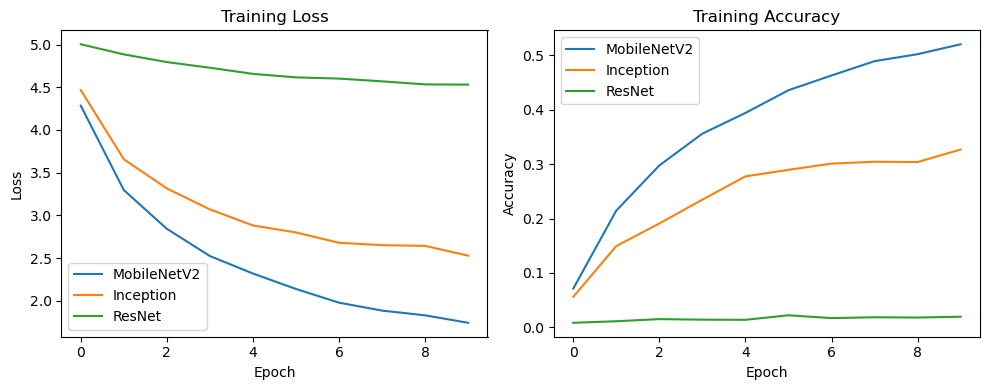

In [56]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['loss'], label='MobileNetV2')
plt.plot(history_inception.history['loss'], label='Inception')
plt.plot(history_resnet.history['loss'], label='ResNet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['accuracy'], label='MobileNetV2')
plt.plot(history_inception.history['accuracy'], label='Inception')
plt.plot(history_resnet.history['accuracy'], label='ResNet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Fine Tuning**

In [100]:
final_base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [101]:
layer_list = (final_base_model.layers)
layer_list

In [102]:
layer_list.reverse()

flag = True
for layers in layer_list:
    if flag:
        layers.trainable=True
    else:
        layers.trainable=False
    if 'Conv_1' in layers.name:
        flag = False

layer_list_names = []
for layer in layer_list:
    layers = str(layer).split(".")
    layer_list_names.append(layers[3])
layer_list_names

['relu',
 'batch_normalization',
 'conv2d',
 'batch_normalization',
 'conv2d',
 'relu',
 'batch_normalization',
 'depthwise_conv2d',
 'relu',
 'batch_normalization',
 'conv2d',
 'add',
 'batch_normalization',
 'conv2d',
 'relu',
 'batch_normalization',
 'depthwise_conv2d',
 'relu',
 'batch_normalization',
 'conv2d',
 'add',
 'batch_normalization',
 'conv2d',
 'relu',
 'batch_normalization',
 'depthwise_conv2d',
 'relu',
 'batch_normalization',
 'conv2d',
 'batch_normalization',
 'conv2d',
 'relu',
 'batch_normalization',
 'depthwise_conv2d',
 'zero_padding2d',
 'relu',
 'batch_normalization',
 'conv2d',
 'add',
 'batch_normalization',
 'conv2d',
 'relu',
 'batch_normalization',
 'depthwise_conv2d',
 'relu',
 'batch_normalization',
 'conv2d',
 'add',
 'batch_normalization',
 'conv2d',
 'relu',
 'batch_normalization',
 'depthwise_conv2d',
 'relu',
 'batch_normalization',
 'conv2d',
 'batch_normalization',
 'conv2d',
 'relu',
 'batch_normalization',
 'depthwise_conv2d',
 'relu',
 'batch_n

In [105]:
base_model = final_base_model

final_model = Sequential([
        base_model,
        Flatten(),
        
        Dense(256, activation='relu'),
        Dropout(0.25),
        BatchNormalization(),
        
        Dense(128, activation='relu'),
        Dropout(0.25),
        BatchNormalization(),
        
        Dense(96, activation='softmax'),  # For binary classification
    ])

final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [106]:
final_model.summary()
history_final = final_model.fit(
    train_dataset,
    steps_per_epoch=120,
    epochs=30,
)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_8 (Flatten)         (None, 62720)             0         
                                                                 
 dense_24 (Dense)            (None, 256)               16056576  
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_110 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dense_25 (Dense)            (None, 128)              

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_8/mobilenetv2_1.00_224/block_1_expand_BN/FusedBatchNormV3' defined at (most recent call last):
    File "d:\Anaconda\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "d:\Anaconda\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "d:\Anaconda\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "d:\Anaconda\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "d:\Anaconda\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "d:\Anaconda\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "d:\Anaconda\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "d:\Anaconda\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "d:\Anaconda\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "d:\Anaconda\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "d:\Anaconda\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "d:\Anaconda\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "d:\Anaconda\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "d:\Anaconda\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "d:\Anaconda\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "d:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "d:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "d:\Anaconda\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "d:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "d:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "d:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\abhag\AppData\Local\Temp\ipykernel_25872\4219794312.py", line 2, in <module>
      history_final = final_model.fit(
    File "d:\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "d:\Anaconda\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "d:\Anaconda\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Anaconda\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "d:\Anaconda\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "d:\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "d:\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "d:\Anaconda\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "d:\Anaconda\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "d:\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "d:\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "d:\Anaconda\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "d:\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "d:\Anaconda\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "d:\Anaconda\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "d:\Anaconda\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 649, in _fused_batch_norm_inference
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential_8/mobilenetv2_1.00_224/block_1_expand_BN/FusedBatchNormV3'
OOM when allocating tensor with shape[32,96,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_8/mobilenetv2_1.00_224/block_1_expand_BN/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_94753]

In [ ]:
plt.figure()